# Preliminary data analysis and pre-processing

In [1]:
from __future__ import division, print_function
from os.path import join
import time

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

from codes import cross_validate_classifier, \
                  format_classifier_performance, \
                  plot_confusion_matrix, metrics_wrapper,construct_confusion_matrix, \
                  get_features_and_labels, load_covertype_data, compress_and_engineer_features

Import the data and specify the column names manually.

In [2]:
data = load_covertype_data()
column_names = list(data)
cover_types = [
    'Spruce/fir',
    'Lodgepole pine',
    'Ponderosa pine',
    'Cottonwood/willow',
    'Aspen',
    'Douglas-fir',
    'Krummholz'
]
data.head()

,Elevation,Aspect_angle,Slope,Horiz_dist_to_nearest_water,Vert_dist_to_nearest_water,Horiz_dist_to_nearest_road,Incident_sunlight_at_9am,Incident_sunlight_at_12pm,Incident_sunlight_at_3pm,Horiz_dist_to_fire_ignition_point,...,Soil_type_31,Soil_type_32,Soil_type_33,Soil_type_34,Soil_type_35,Soil_type_36,Soil_type_37,Soil_type_38,Soil_type_39,Cover_type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [3]:
data[column_names[:10]].describe(percentiles=[0.1, 0.5, 0.9])

,Elevation,Aspect_angle,Slope,Horiz_dist_to_nearest_water,Vert_dist_to_nearest_water,Horiz_dist_to_nearest_road,Incident_sunlight_at_9am,Incident_sunlight_at_12pm,Incident_sunlight_at_3pm,Horiz_dist_to_fire_ignition_point
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,2959.365301,155.656807,14.103704,269.428217,46.418855,2350.146611,212.146049,223.318716,142.528263,1980.291226
std,279.984734,111.913721,7.488242,212.549356,58.295232,1559.254870,26.769889,19.768697,38.274529,1324.195210
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10%,2581.000000,24.000000,5.000000,30.000000,0.000000,591.000000,176.000000,198.000000,95.000000,595.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000
90%,3272.000000,329.000000,24.000000,564.000000,121.000000,4793.000000,241.000000,247.000000,191.000000,3747.000000
max,3858.000000,360.000000,66.000000,1397.000000,601.000000,7117.000000,254.000000,254.000000,254.000000,7173.000000


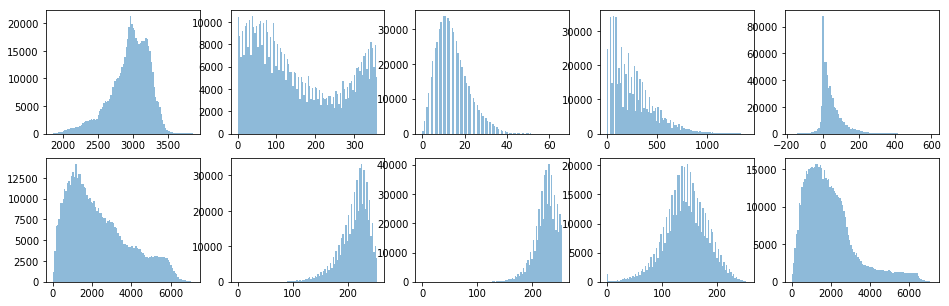

In [4]:
fig = plt.figure(figsize=(16, 5))
layout = (2, 5)
gs = GridSpec(*layout)
axes = [plt.subplot(gs[np.unravel_index(i, layout)]) for i in range(10)]

for i in range(10):
    ax = axes[i]
    hist, bin_edges, _ = ax.hist(data[column_names[i]], bins=100, alpha=0.5)
plt.show()

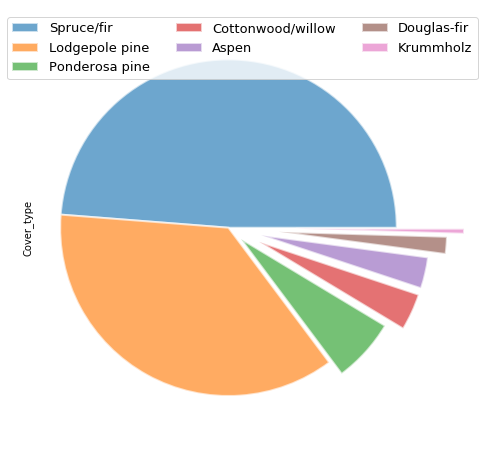

[0.48759922 0.36460521 0.06153746 0.03530048 0.02989095 0.01633873
 0.00472796]


In [5]:
#cmap = plt.cm.get_cmap('plasma')
#class_colours = np.array([cmap(i) for i in np.arange(7)/7])
class_colours = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])

fig = plt.figure(figsize=(8, 8))
data['Cover_type'].value_counts().plot(
    kind='pie', explode=(0, 0, 0.1, 0.2, 0.2, 0.3, 0.4),
    wedgeprops={'linewidth':2, 'edgecolor': 'w', 'alpha': 0.65}, labels=None,
    colors=class_colours, fontsize=16
)
plt.axis('equal')
plt.legend(labels=cover_types, fontsize=13, ncol=3)
fig.savefig('covertypes_pie_chart_new.svg')
plt.show()

print(data['Cover_type'].value_counts().values / 581012)

In [6]:
column_correlations = data[column_names[:10]].corr(method='pearson')

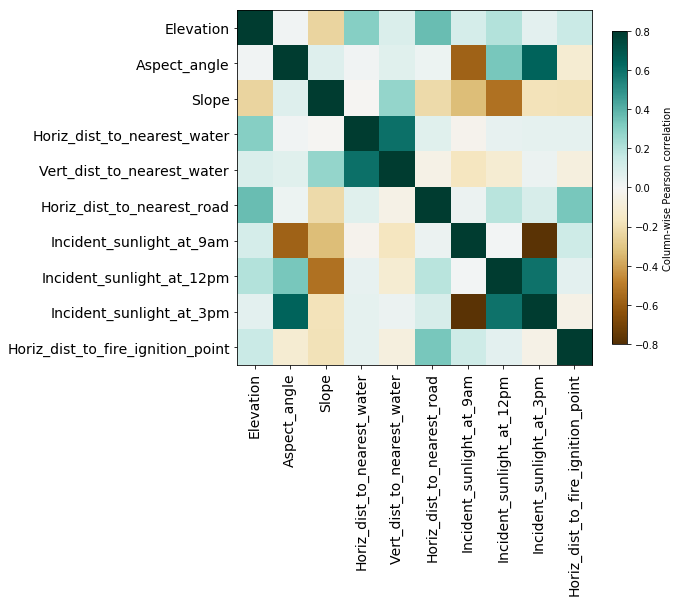

In [7]:
fig, ax = plt.subplots(figsize=(7, 7))
im = ax.imshow(column_correlations, cmap=plt.cm.BrBG,
          vmin=-0.8, vmax=0.8, interpolation='nearest')
cbar = plt.colorbar(im, fraction=0.04)
cbar.set_label('Column-wise Pearson correlation')
ticks = np.arange(0, 10, 1); labels = np.array(column_names[:10])[ticks]
ax.set_xticks(ticks); ax.set_yticks(ticks)
ax.set_yticklabels(labels, fontsize=14)
ax.set_xticklabels(labels, fontsize=14, rotation=90)

plt.show()

## How features separate classes

In [10]:
def plot_class_observations_per_feature(feature_column, name=None, bins=300):
    """
        This function counts the number of class observations for given ranges
        of feature columns. By plotting the resulting histograms, we can observe
        how features separate classes.
    """
    row_indices_split = np.array_split(feature_column.argsort(), bins)
    binned_values = np.linspace(feature_column.min(), feature_column.max(), num=bins)

    # Loop over each set of rows and count the occurrences of each
    # class
    class_counts = np.zeros((bins, 7))
    for i, row_indices in enumerate(row_indices_split):
        # Count classes for this set of observations
        classes, counts = np.unique(labels[row_indices], return_counts=True)
        class_counts[i, classes] = counts

    feature_name = name if name is not None else ''
    fig, ax = plt.subplots(figsize=(16, 5))
    for i in range(7):
        cts = class_counts[:, i]
        ax.fill_between(binned_values, cts, 0, alpha=0.2)
        ax.plot(binned_values, cts, alpha=0.8, label=cover_types[i])
        #ax.bar(binned_values, cts, alpha=0.35 + i*0.05)
    ax.set_ylabel('Class counts')
    ax.set_xlabel(feature_name)
    ax.set_title('Number of class observations per feature: ' + feature_name)
    ax.legend(ncol=4)
    return fig, ax

## Class separation through continuous variables

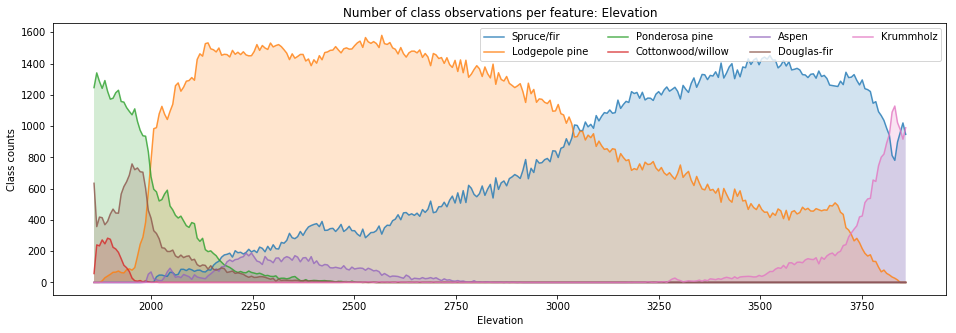

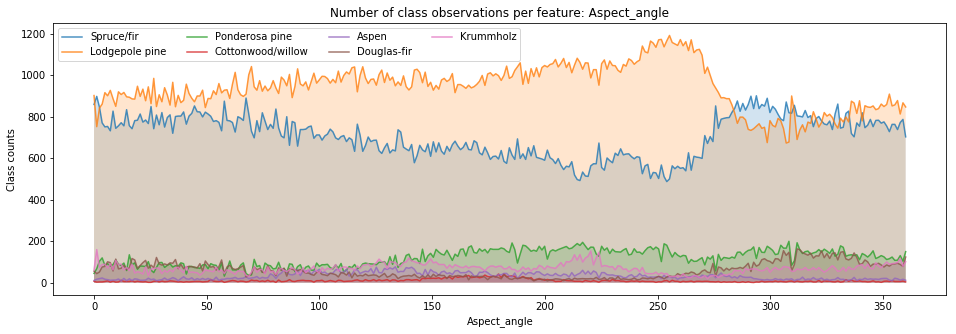

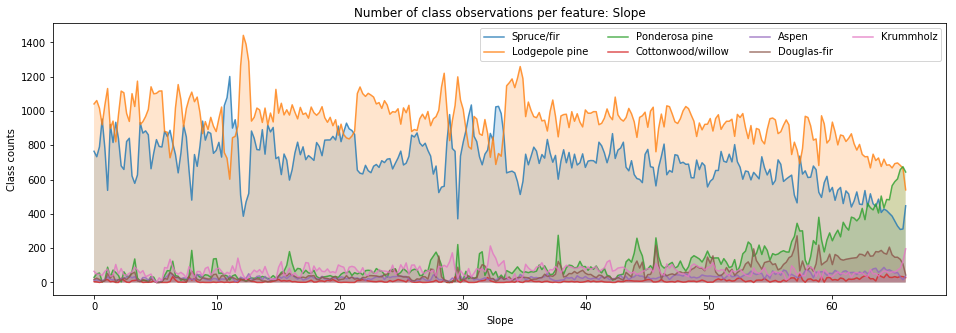

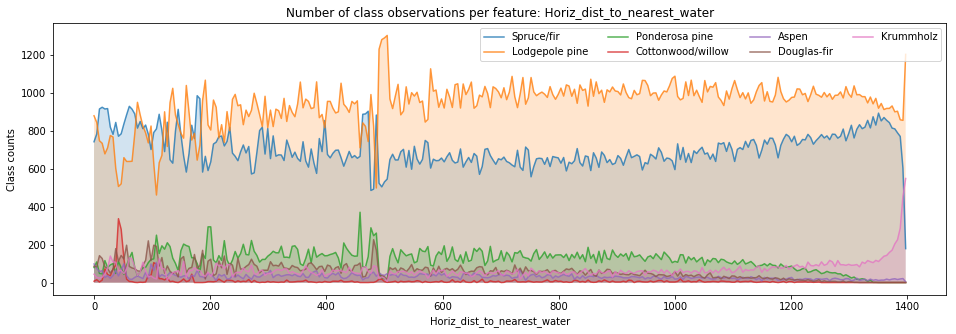

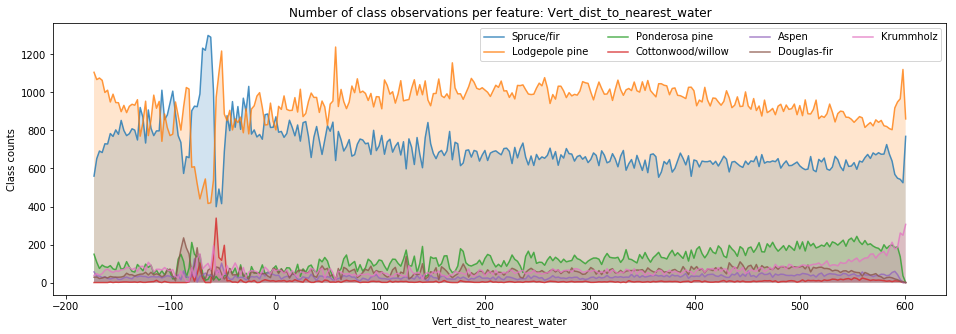

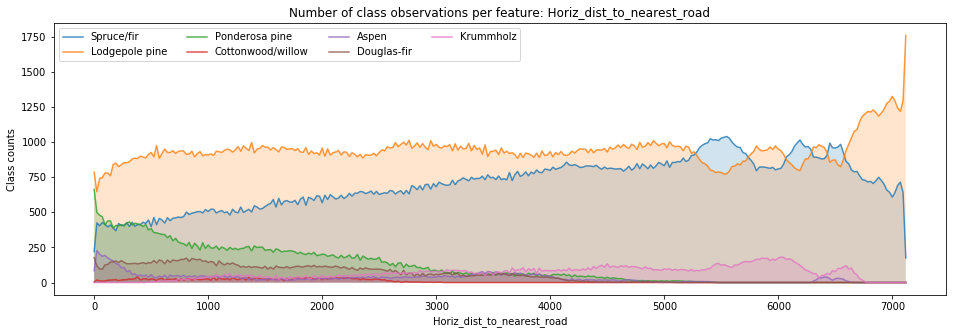

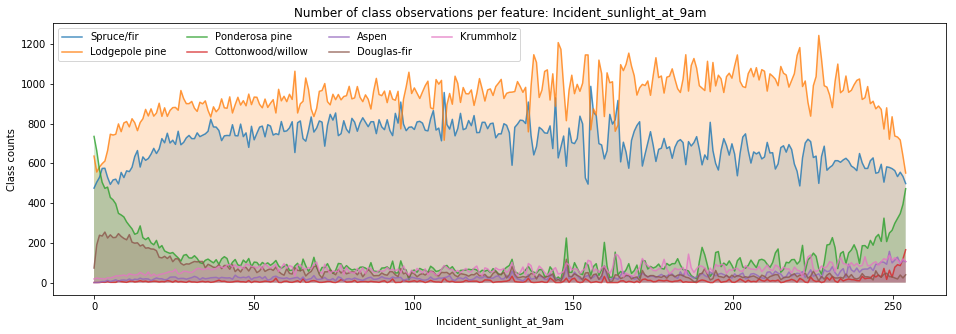

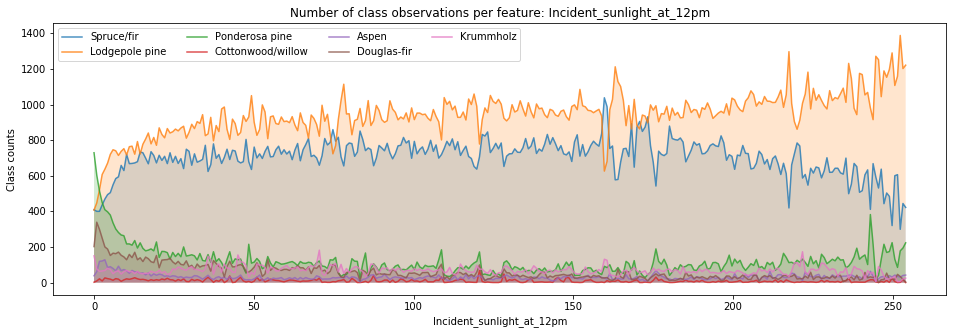

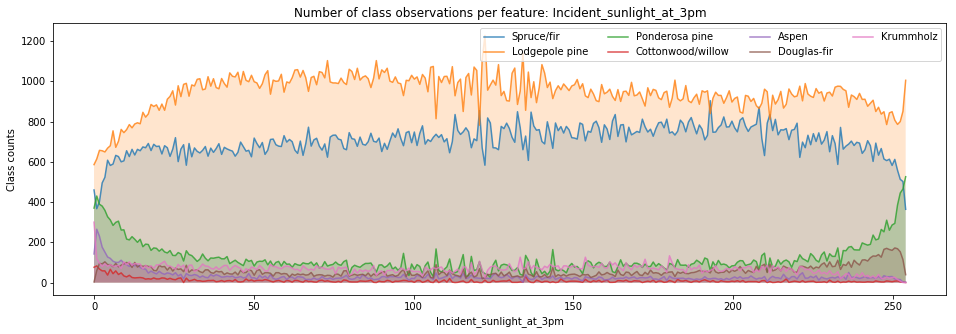

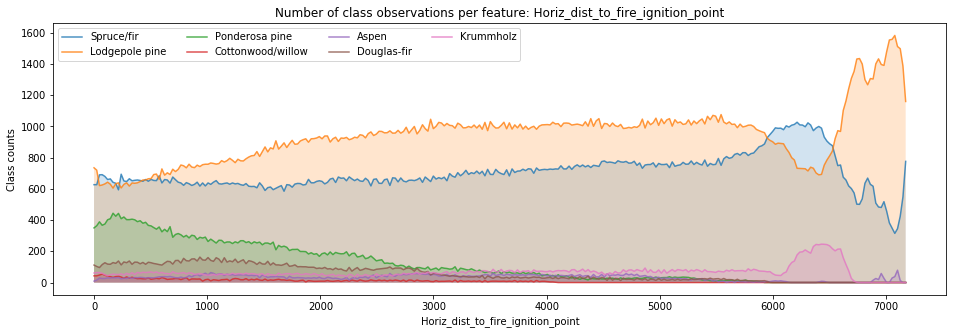

In [15]:
for feature_name in column_names[:10]:
    feature_column = data[feature_name].values
    fig, ax = plot_class_observations_per_feature(feature_column, name=feature_name)
    #if feature_name == 'Elevation':
    #    plt.savefig('Elevation_hist.svg')
    #elif feature_name == 'Incident_sunlight_at_3pm':
    #    plt.savefig('Sunlight_3pm_hist.svg')
    
plt.show()

## Class separation by soil and wilderness areas

In [12]:
labels_per_area = [labels[np.where(w_col == 1)] for w_col in wilderness_areas.T]
fig = plt.figure(figsize=(16, 4))
gs = GridSpec(1, 4)

axes = [plt.subplot(gs[0, i]) for i in range(4)]

for i, ax in enumerate(axes):
    classes, class_counts = np.unique(labels_per_area[i], return_counts=True)
    ax.pie(class_counts, labels=np.array(cover_types)[classes], autopct='%1.1f%%',
        colors=class_colours[classes],
                 wedgeprops={'linewidth':1, 'edgecolor': 'w', 'alpha': 0.65})
    h, l = ax.get_legend_handles_labels()
plt.tight_layout()
plt.savefig('wilderness_areas_pie_charts.svg')
plt.show()

plot_class_observations_per_feature(soil_types_new, 'Soil type', bins=40)
plt.show()

NameError: name 'wilderness_areas' is not defined

## Create features and extract labels

In [14]:
data_new = compress_and_engineer_features(data)
features, labels = get_features_and_labels(data_new)
labels = labels.astype(np.int16)
print(features.shape, labels.dtype)

print(list(data_new))

(581012, 19) int16
['Elevation', 'Aspect_angle', 'Slope', 'Horiz_dist_to_nearest_water', 'Vert_dist_to_nearest_water', 'Horiz_dist_to_nearest_road', 'Incident_sunlight_at_9am', 'Incident_sunlight_at_12pm', 'Incident_sunlight_at_3pm', 'Horiz_dist_to_fire_ignition_point', 'Wilderness_area', 'Soil_types', 'Elevation_plus_road_dist', 'Elevation_minus_road_dist', 'Elevation_plus_fire_dist', 'Elevation_minus_fire_dist', 'Elevation_times_soil_types', 'Elevation_times_wArea', 'wArea_times_soil_types', 'Cover_type']


In [133]:
# Take a peek at the baseline accuracy (always predict class 1)
print(format_classifier_performance(construct_confusion_matrix(labels, np.ones_like(labels))))


    Overall Accuracy: 0.488
    Mean Precision:   0.070 +/- 0.171
    Mean Recall:      0.143 +/- 0.350
    Mean F1 Score:    nan +/- nan
    


In [77]:
# Quick testing of tree visualisation with graphviz
import graphviz
from sklearn import tree
# get 10 data points, 5 of ponderosa pine and 5 of krummholz
class_1_points = np.where(labels == 2)[0][
    np.random.randint(low=0, high=2000, size=(3,))]
class_2_points = np.where(labels == 6)[0][
    np.random.randint(low=0, high=2000, size=(3,))]

# Get the data for both classes
data_ = []
target_ = []

feature_cols = [0, 2, 11]
feature_names = np.array(list(data_new))[feature_cols]

for c1, c2 in zip(class_1_points, class_2_points):
    data_.append(features[c1, feature_cols])
    target_.append(0)
    data_.append(features[c2, feature_cols])
    target_.append(1)
data_ = np.array(data_)
target_ = np.array(target_)

print(data_.shape)

clf = RandomForestClassifier(n_estimators=3)
clf = clf.fit(data_, target_)

trees = clf.estimators_

for i, t in enumerate(trees):
    tree_data = tree.export_graphviz(
        t, out_file=None, feature_names=feature_names,  
                         class_names=['Ponderosa Pine', 'Krummholz'],  
                         filled=True, rounded=True, leaves_parallel=True)
    graph = graphviz.Source(tree_data)
    graph.render("tree_{}".format(i))


clf.feature_importances_
# 0.58333333, 0.08333333, 0.33333333

(6, 3)


array([0.6       , 0.06666667, 0.33333333])

In [78]:
df = pd.DataFrame(data_, columns=np.array(list(data_new))[feature_cols])
df

,Elevation,Slope,Soil_types
0,2506.0,21.0,3.0
1,3552.0,21.0,39.0
2,2447.0,39.0,9.0
3,3350.0,20.0,38.0
4,2520.0,16.0,3.0
5,3329.0,5.0,37.0


[0.6        0.06666667 0.33333333]


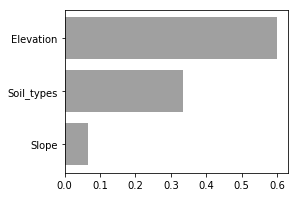

In [79]:
f = clf.feature_importances_
print(f)
sort_indices = np.argsort(f)

feature_names = np.array(list(data_new))[feature_cols][sort_indices]

x_axis = np.arange(len(f))
fig, ax = plt.subplots(figsize=(4, 3))
ax.barh(x_axis, f[sort_indices],
        alpha=0.75, color='Gray')
ax.set_yticks(x_axis)

ax.set_yticklabels(feature_names)
plt.savefig('feature_importances_toy_example.svg')
plt.show()

## Outlier removal (not used at the moment)

In [5]:
# Remove data that lies outside 10-90% (or some other range)
numeric_data = data[column_names[:10]]
bool_array = (
    ( numeric_data > numeric_data.quantile(1e-4) )
    & ( numeric_data < numeric_data.quantile(1-1e-4) ).values
)
rows_to_keep = np.all(bool_array, axis=1)
#features = features[rows_to_keep]
#labels = labels[rows_to_keep]

## RandomForest classification

In [105]:
# Normalising features
#norm_features = np.zeros_like(full_features)
#for i in range(full_features.shape[1]):
##    norm_features[:, i] = (
 #       full_features[:, i] - np.min(full_features[:, i])) / (
#        np.max(full_features[:, i]) - np.min(full_features[:, i]))


tic = time.time()
cms, clfs = cross_validate_classifier(RandomForestClassifier,
                               features, labels,
                                kfold=2, kwargs={'n_estimators': 10, 'n_jobs': 8, 'bootstrap': True,
                                                'criterion': 'gini', 'oob_score': True,
                                                })
toc = time.time() - tic
print('Ran Classifier in {:.2f} s.'.format(toc))

/home/virginia/.local/lib/python2.7/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/virginia/.local/lib/python2.7/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


Ran Classifier in 16.36 s.


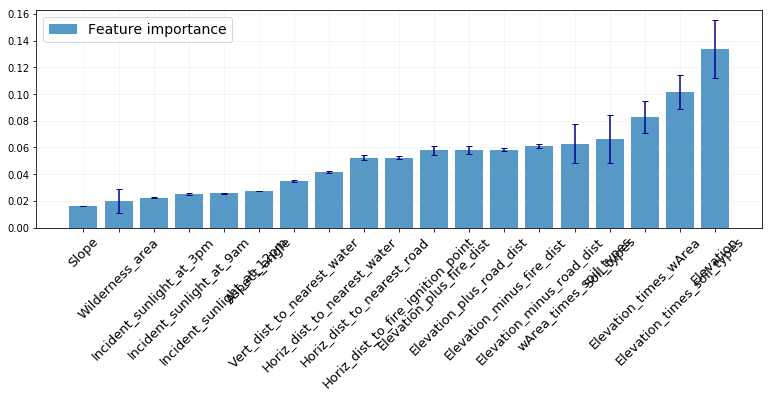

In [85]:
feature_importances = np.mean([clf.feature_importances_ for clf in clfs], axis=0)
feature_importances_stderr = np.std([clf.feature_importances_ for clf in clfs], axis=0)
sort_indices = np.argsort(feature_importances)
num_features = len(feature_importances)
x_axis = np.arange(num_features)
fig, ax = plt.subplots(figsize=(13, 4))
ax.bar(x_axis, feature_importances[sort_indices],
        yerr=feature_importances_stderr[sort_indices], capsize=3, alpha=0.75, ecolor='DarkBlue',
       label='Feature importance')
ax.set_xticks(x_axis)
feature_names = np.array(list(data_new))
ax.set_xticklabels(feature_names[sort_indices], fontsize=13, rotation=45)
ax.grid(True, ls='-', alpha=0.15)
ax.legend(fontsize=14)
plt.savefig('feature_importances.svg')
plt.show()

In [19]:
sort_indices

array([ 2, 10,  8,  6,  7,  1,  4,  3,  9,  5, 11, 12, 14, 15, 13, 18, 17,
       16,  0])

In [106]:
print(format_classifier_performance(np.mean(cms, axis=0)))
#plot_confusion_matrix(cms)
df_total, df_class, df_conf = metrics_wrapper(np.mean(cms, axis=0), cover_types, do_display=True)


    Overall Accuracy: 0.967
    Mean Precision:   0.954 +/- 0.021
    Mean Recall:      0.926 +/- 0.053
    Mean F1 Score:    0.940 +/- 0.036
    
Average/overall metrics:


,Average F-Meas,Average Precision,Average Recall,Overall Accuracy
Class-Averaged or Overall:,0.94,0.95,0.93,0.97


Class-specific metrics:


,Class,F-Meas,Precision,Recall
Confusion Matrix Index,,,,
0,Spruce/fir,0.97,0.96,0.97
1,Lodgepole pine,0.97,0.97,0.97
2,Ponderosa pine,0.96,0.95,0.97
3,Cottonwood/willow,0.88,0.91,0.85
4,Aspen,0.89,0.95,0.84
5,Douglas-fir,0.94,0.95,0.92
6,Krummholz,0.97,0.98,0.96


Confusion matrix (yellow = col max; red = row max):


Predicted,0,1,2,3,4,5,6
Actual,,,,,,,
0,20575,565.5,0,0,6.5,1,36
1,666.5,27571.5,32,0,34.5,22,4.5
2,1.5,47,3465,15,2.5,44,0
3,0,0,33,234.5,0,7.5,0
4,16.5,124.5,7,0,799.5,1.5,0
5,0.5,34.5,97,8.5,2,1594.5,0
6,79,10.5,0,0,0,0,1961.5


## RandomForest with full dataset (~95%)

In [26]:
# There is a slight increase when removing a fraction of 1e-6 compared to 1e-5 (and higher) and the full dataset.
# 0.00001
#Overall Accuracy: 0.943
#Mean Precision:   0.942 +/- 0.016
#Mean Recall:      0.865 +/- 0.092
#Mean F1 Score:    0.899 +/- 0.053

# 0.000001
#Overall Accuracy: 0.944
#   Mean Precision:   0.944 +/- 0.018
#Mean Recall:      0.874 +/- 0.085
#   Mean F1 Score:    0.905 +/- 0.049

# Full
#Overall Accuracy: 0.941
#    Mean Precision:   0.932 +/- 0.024
#    Mean Recall:      0.873 +/- 0.084
#    Mean F1 Score:    0.900 +/- 0.052


#features = data[column_names[:1] + column_names[10:-1]].values
features_ = data[column_names[:10]].values
labels = data['Cover_type'].values - 1
print(features_.shape, labels.shape)

# interesting: PCA with 5 components gives roughly same accurarcy as full dataset
#from sklearn.decomposition import PCA
#pca = PCA(n_components=5, whiten=True)
#features_new = pca.fit_transform(features)

#for i in range(10):
#    features[:, i] = (features[:, i] - np.min(features[:, i])) / (np.max(features[:, i]) - np.min(features[:, i]))

tic = time.time()
cms = cross_validate_classifier(RandomForestClassifier,
                               features_compressed, labels,
                                kfold=2, kwargs={'n_estimators': 10, 'n_jobs': 6}, style='random')
toc = time.time() - tic
print('Ran Classifier in {:.2f} s.'.format(toc))

(581012, 10) (581012,)
Ran Classifier in 10.22 s.


In [27]:
print(format_classifier_performance(np.mean(cms, axis=0)))
#plot_confusion_matrix(cms)
df_total, df_class, df_conf = metrics_wrapper(np.mean(cms, axis=0), cover_types, do_display=True)


    Overall Accuracy: 0.957
    Mean Precision:   0.947 +/- 0.019
    Mean Recall:      0.909 +/- 0.064
    Mean F1 Score:    0.927 +/- 0.040
    
Average/overall metrics:


,Average F-Meas,Average Precision,Average Recall,Overall Accuracy
Class-Averaged or Overall:,0.93,0.95,0.91,0.96


Class-specific metrics:


,Class,F-Meas,Precision,Recall
Confusion Matrix Index,,,,
0,Spruce/fir,0.96,0.96,0.96
1,Lodgepole pine,0.96,0.96,0.97
2,Ponderosa pine,0.95,0.94,0.96
3,Cottonwood/willow,0.88,0.92,0.84
4,Aspen,0.86,0.94,0.79
5,Douglas-fir,0.91,0.94,0.89
6,Krummholz,0.97,0.98,0.95


Confusion matrix (yellow = col max; red = row max):


Predicted,0,1,2,3,4,5,6
Actual,,,,,,,
0,20385.5,783.5,0.5,0,4.5,2.5,35
1,838.5,27258,53,0.5,37,30.5,7
2,1,55.5,3446,11,4,65.5,0
3,0,0,38,250,0,8.5,0
4,19,172,9,0,765,2,0
5,2.5,54.5,125.5,11,1,1574.5,0
6,89.5,9.5,0,0,0.5,0,1951


## Scan parameter of the RandomForestClassifier

In [87]:
#from sklearn.decomposition import PCA
#pca = PCA(n_components=5, whiten=True)
#features_new = pca.fit_transform(features)

def scan_parameter(parameter, parameter_values, kwargs=None):
    accuracies_mean = []
    run_times = []
    if kwargs is None:
        kwargs = {}
    for param_val in parameter_values:
        kwargs[parameter] = param_val
        tic = time.time()
        cms, _ = cross_validate_classifier(RandomForestClassifier,
                                   features, labels,
                                    kfold=2, kwargs=kwargs, style='prop')
        toc = time.time() - tic
        print('Ran Classifier in {:.2f} s.'.format(toc))
        run_times.append(toc)
        
        accuracies = [np.sum(np.diag(c)) / np.sum(c) for c in cms]
        accuracies_mean.append((np.mean(accuracies), np.std(accuracies)))
    return accuracies_mean, run_times

def plot_accuracies_and_runtime(accuracies_mean, run_times, parameter, parameter_values, alias=None,
                                save_to_txt=False):
    
    accuracies = np.array(accuracies_mean)

    fig, ax1 = plt.subplots(figsize=(16, 4))
    ax1.errorbar(parameter_values, accuracies[:, 0], yerr=accuracies[:, 1], fmt='o-')
    ax2 = ax1.twinx()
    ax2.plot(parameter_values, run_times, 'ks-', alpha=0.75, mfc='none')
    ax1.set_xlabel(alias if alias is not None else parameter)
    ax1.set_ylabel('Overall Accuracy')
    ax2.set_ylabel('Runtime (s)')
    ax1.grid(True, ls='-', alpha=0.2)
    plt.show()
    print('Accuracies: ' + ',  '.join(['{:.2f}'.format(a) for a in accuracies[:, 0]]))
    if save_to_txt:
        np.savetxt(parameter+'.txt', np.hstack((accuracies, np.array(run_times)[:, np.newaxis])))

## Number of estimators

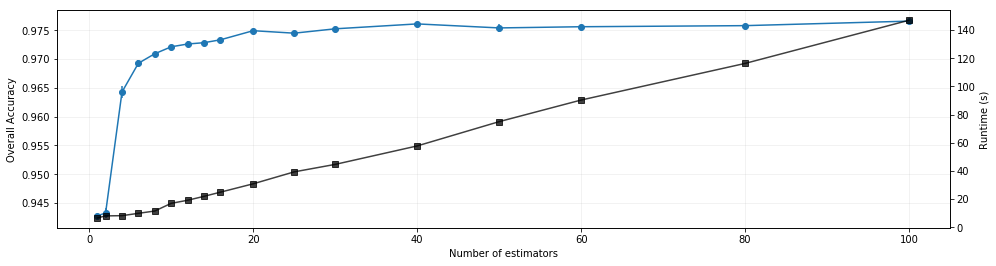

Accuracies: 0.94,  0.94,  0.96,  0.97,  0.97,  0.97,  0.97,  0.97,  0.97,  0.97,  0.97,  0.98,  0.98,  0.98,  0.98,  0.98,  0.98


In [63]:
parameter = 'n_estimators'
parameter_values = [1, 2, 4, 6, 8, 10, 12, 14, 16, 20, 25, 30, 40, 50, 60, 80, 100]#, 20, 30, 50, 60, 80, 100]
#confs_1, run_times_1 = scan_parameter(parameter, parameter_values, kwargs={'n_jobs': 8, 'bootstrap': False})
plot_accuracies_and_runtime(confs_1, run_times_1, 
                            parameter, parameter_values, 'Number of estimators', save_to_txt=True)

## Number of features for each split decision

Ran Classifier in 11.28 s.
Ran Classifier in 15.58 s.
Ran Classifier in 25.44 s.
Ran Classifier in 36.40 s.
Ran Classifier in 47.35 s.
Ran Classifier in 57.70 s.
Ran Classifier in 69.21 s.
Ran Classifier in 81.09 s.
Ran Classifier in 88.71 s.


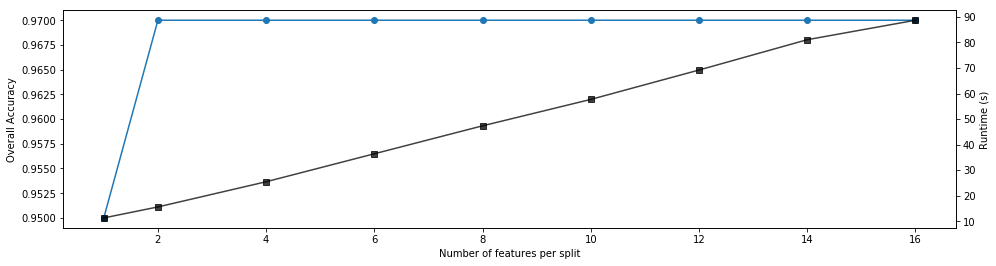

Accuracies: 0.95,  0.97,  0.97,  0.97,  0.97,  0.97,  0.97,  0.97,  0.97


In [86]:
parameter = 'max_features'
parameter_values = [1, 2, 4, 6, 8, 10, 12, 14, 16]#[1, 2, 5, 7, 10, 15, 20, 30, 40, 54]
confs_2, run_times_2 = scan_parameter(parameter, parameter_values,
                       kwargs={'n_jobs': 8, 'n_estimators': 10, 'bootstrap': False})
plot_accuracies_and_runtime(confs_2, run_times_2, parameter, parameter_values, 'Number of features per split')

## Maximum tree depth

Ran Classifier in 6.76 s.
Ran Classifier in 11.12 s.
Ran Classifier in 14.22 s.
Ran Classifier in 15.65 s.
Ran Classifier in 16.49 s.
Ran Classifier in 17.69 s.
Ran Classifier in 18.08 s.
Ran Classifier in 17.69 s.
Ran Classifier in 17.58 s.
Ran Classifier in 17.61 s.
Ran Classifier in 17.67 s.
Ran Classifier in 17.77 s.


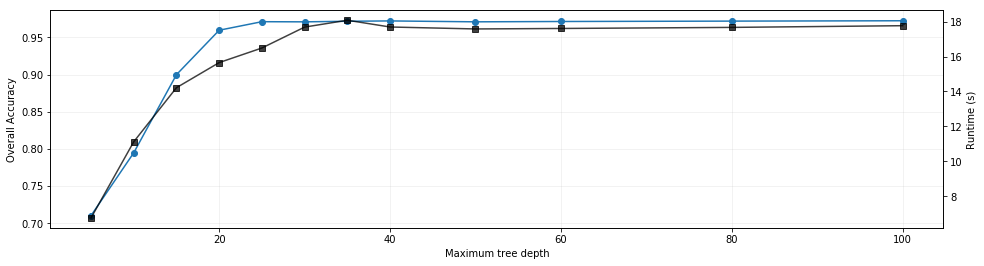

Accuracies: 0.71,  0.79,  0.90,  0.96,  0.97,  0.97,  0.97,  0.97,  0.97,  0.97,  0.97,  0.97


In [64]:
parameter = 'max_depth'
parameter_values = [5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 80, 100]
confs_3, run_times_3 = scan_parameter(parameter, parameter_values,
                       kwargs={'n_jobs': 6, 'n_estimators': 10, 'bootstrap': False})
plot_accuracies_and_runtime(confs_3, run_times_3, parameter, parameter_values, 'Maximum tree depth', save_to_txt=True)

## Minimum impurity decrease

Ran Classifier in 18.07 s.
Ran Classifier in 16.90 s.
Ran Classifier in 14.20 s.
Ran Classifier in 9.34 s.


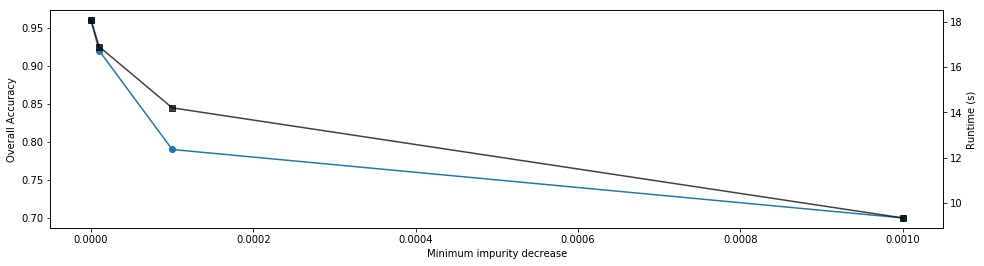

Accuracies: 0.96,  0.92,  0.79,  0.70


In [55]:
parameter = 'min_impurity_decrease'
parameter_values = [0, 1e-5, 1e-4, 1e-3]
confs_4, run_times_4 = scan_parameter(parameter, parameter_values,
                       kwargs={'n_jobs': 6, 'n_estimators': 20})
plot_accuracies_and_runtime(confs_4, run_times_4, parameter, parameter_values, 'Minimum impurity decrease')

## Minimum number of samples per split

Ran Classifier in 26.03 s.
Ran Classifier in 26.55 s.
Ran Classifier in 26.82 s.


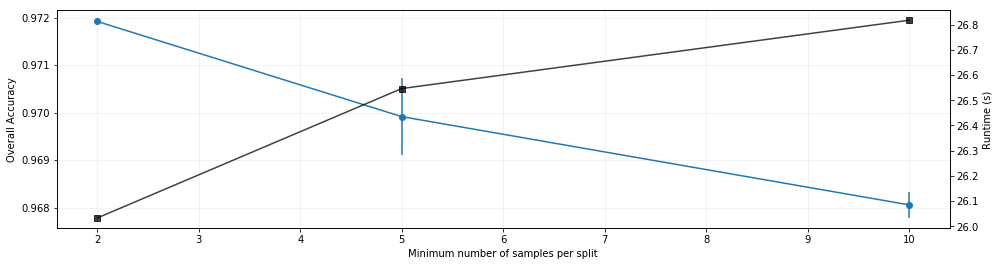

Accuracies: 0.97,  0.97,  0.97


In [89]:
parameter = 'min_samples_split'
parameter_values = [2, 5, 10]
confs_5, run_times_5 = scan_parameter(parameter, parameter_values,
                       kwargs={'n_jobs': 6, 'n_estimators': 20})
plot_accuracies_and_runtime(confs_5, run_times_5, parameter, parameter_values, 'Minimum number of samples per split')

## Minimum number of samples per leaf

Ran Classifier in 26.34 s.
Ran Classifier in 24.88 s.
Ran Classifier in 28.79 s.
Ran Classifier in 25.10 s.


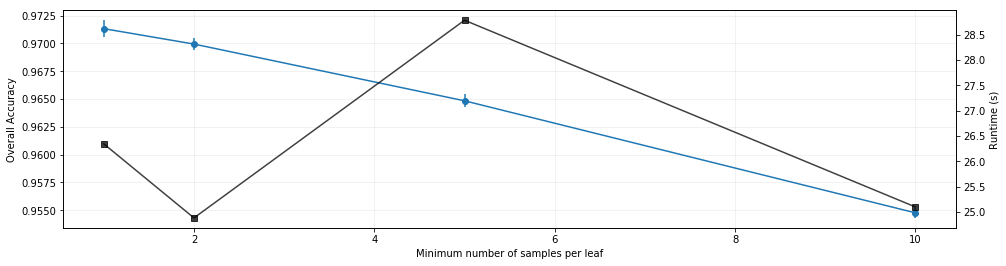

Accuracies: 0.97,  0.97,  0.96,  0.95


In [92]:
parameter = 'min_samples_leaf'
parameter_values = [1, 2, 5, 10]
confs_6, run_times_6 = scan_parameter(parameter, parameter_values,
                       kwargs={'n_jobs': 6, 'n_estimators': 20})
plot_accuracies_and_runtime(confs_6, run_times_6, parameter, parameter_values, 'Minimum number of samples per leaf')

## Final, optimised results for the RandomForestClassifier

In [99]:
tic = time.time()
cms = cross_validate_classifier(RandomForestClassifier,
                               features, labels,
                                kfold=10, kwargs={'n_estimators': 40, 'n_jobs': 8, 'max_depth': 30,
                                                 'max_features': 5, 'min_impurity_decrease': 0,
                                                 'min_samples_leaf': 1, 'min_samples_split': 2,
                                                 'bootstrap': False})
toc = time.time() - tic
print('Ran Classifier in {:.2f} s.'.format(toc))

Ran Classifier in 403.36 s.


In [100]:
print(format_classifier_performance(np.mean(cms[0], axis=0)))
#plot_confusion_matrix(cms)
df_total, df_class, df_conf = metrics_wrapper(np.mean(cms[0], axis=0), cover_types, do_display=True)


    Overall Accuracy: 0.976
    Mean Precision:   0.961 +/- 0.020
    Mean Recall:      0.949 +/- 0.036
    Mean F1 Score:    0.955 +/- 0.028
    
Average/overall metrics:


,Average F-Meas,Average Precision,Average Recall,Overall Accuracy
Class-Averaged or Overall:,0.95,0.96,0.95,0.98


Class-specific metrics:


,Class,F-Meas,Precision,Recall
Confusion Matrix Index,,,,
0,Spruce/fir,0.98,0.98,0.97
1,Lodgepole pine,0.98,0.98,0.98
2,Ponderosa pine,0.97,0.97,0.98
3,Cottonwood/willow,0.91,0.92,0.89
4,Aspen,0.92,0.94,0.9
5,Douglas-fir,0.96,0.96,0.95
6,Krummholz,0.97,0.98,0.97


Confusion matrix (yellow = col max; red = row max):


Predicted,0,1,2,3,4,5,6
Actual,,,,,,,
0,20639.1,499.3,0.4,0,5.9,1.1,38.2
1,429.9,27807.6,28.8,0,42.5,15.7,6.5
2,0.2,31.1,3493.3,13,4.3,33.1,0
3,0,0,22.4,244.6,0,8,0
4,8.7,79,6.6,0,851.6,2.8,0.3
5,1.2,23.6,52,7.4,1.4,1651.4,0
6,51.9,6.8,0,0,0.4,0,1991.9
